<p style='text-align: justify;'>
<b>Ejercicio 2:</b> Iris  es  el  género  de  una  planta  herbácea  con  flores  que  se  utilizan  en decoración. Dentro de este género existen muy diversas especies, entre las que se han estudiado: Iris setosa, Iris versicolor e Iris virginica (ver Figura 2).
Estas tres especies pueden distinguirse según las dimensiones de sus pétalos y sépalos.  Un  grupo  de  investigadores  ha  recopilado  la  información  correspondiente a las longitudes y anchos de los pétalos y sépalos de 50 plantas de cada especie. En el archivo irisbin <i>trn.csv</i> se encuentra el conjunto de entrenamiento, y en irisbin <i>tst.csv</i> el de prueba, generado a partir de estas mediciones  (en  cm),  junto  con  un  código  binario  que  indica  la  clase  de  cada  muestra (especie) reconocida por el grupo de investigadores ([−1, −1, 1] = setosa, [−1, 1, −1] = versicolor, [1, −1, −1] = virginica).
Determine la estructura óptima de un perceptrón multicapa para resolver este problema.  Explore  cómo  varía  el  desempeño  al  usar  distintas  tasas  de  aprendizaje,  y  para  cada  caso  grafique  las  curvas  de  error  cuadrático  total  y  error de clasificación en función de las épocas de entrenamiento.</p>

#### <b>Librerías</b>

In [64]:
import random
import csv
import numpy as np
import matplotlib.pyplot as plt

#### **Paso 1:** Inicialización
Determino la estructura de mi red neuronal: el número de capas y neuronas para cada capa. En la variable *cant_entradas*, el primer elemento son las entradas x1,x2,... del archivo, mientras que los próximos elementos me determinan la cantidad de neuronas por capa. 

In [65]:
cant_entradas = np.array([4,2,3]) # Variable a cambiar según mi red neuronal

cant_capas = len(cant_entradas) - 1
cant_salidas = cant_entradas[cant_capas]

Levantamos los datos del archivo .csv, separando en un vector para las entradas y otro para las salidas esperadas. En este caso, entrenamos y probamos el algoritmo con el problema irisben, para lo cual usaremos una red de dos capas y cuatro entradas x_i. La capa de entrada tendrá 2 neuronas y la capa de salida tendrá 3 neuronas para realizar la clasificación. 

También se podría resolver este problema con una capa de entrada de una sola neurona (arquitectura 1-3) debido a que usamos la función sigmoidea como función de activación y, viendo las gráficas de relación entre las entradas, permitiría clasificar las tres posibles clases en distintos rangos (por ejemplo, la azul en -1, la verde en 1 y la naranja en el medio).


In [66]:
trn = np.loadtxt('./data/irisbin_trn.csv',delimiter=',')

inputs = np.empty(len(trn),dtype=object)      # Vector de entradas
yd = np.empty(len(trn),dtype=object)       # Salida esperadas
for i in range(len(trn)):
    fila = trn[i]
    cant_e = cant_entradas[0]   # Cantidad de entradas
    yd[i] = fila[cant_e:]
    aux = [-1]                  # Añado entrada -1 correspondiente al umbral/sesgo
    for j in range(cant_e):
        aux.append(fila[j])
    inputs[i] = aux             

Inicializo al azar las matrices de pesos de cada capa.

In [67]:
# Inicializo la matriz de pesos para cada una de las capas.
w = []
for i in range(len(cant_entradas)-1):
    w_aux = np.random.rand(cant_entradas[i+1],cant_entradas[i]+1)-0.5
    w.append(w_aux)     # Añado al vector de matrices de pesos

# Estructura de la matriz:
print(w)
# El elemento w_ij = w[i][j] de la matriz me da los pesos correspondientes a la neurona j de la capa i. 
# El elemento w_ij[k] me da el peso asociado a la entrada k de la neurona j de la capa i.

y = np.empty(cant_capas,dtype=object)
delta = np.empty(cant_capas,dtype=object)

[array([[-0.24780944, -0.18027418,  0.42820044, -0.33105727,  0.45423768],
       [ 0.1022096 ,  0.04155827,  0.23543435, -0.3836559 ,  0.36685097]]), array([[ 0.3466558 ,  0.13452332, -0.17843861],
       [-0.42746034,  0.48177697, -0.48934077],
       [ 0.18339565, -0.02088365, -0.48348108]])]


#### **Paso 2:** Entrenamiento
Continuando con el algoritmo, realizamos los pasos de propagación hacia adelante, propagación hacia atrás y adaptación de los pesos en distintas épocas para todas las capas de nuestra red neuronal. Realizamos una pasada de aprendizaje y otra de validación para evaluar el desempeño del mismo.

Defino funciones auxiliares para la sigmoidea y su derivada a modo de simplificar el código:

In [68]:
def sigmoidea(v):
    return ((2/(1+np.exp(-v)))-1)

def d_sigmoidea(y):
    return ((1+y)*(1-y))

In [69]:
# DATOS PARA EL ALGORITMO:
epoca = 1               # Contador para época actual
epoca_max = 2000        # Máximo de iteraciones
mu = 0.01               # Velocidad de aprendizaje
perc_error_max = 0.03   # Porcentaje máximo de error
errores_por_epoca = []
mse_por_epoca = []

while (epoca < epoca_max):  
    
    #--------------------------------#
    #--------- Aprendizaje ----------#
    #--------------------------------#

    for patron in range(len(trn)):

        # PROPAGACIÓN HACIA ADELANTE: Obtengo la salida de las capas y las propago como entradas de las próximas
        entradas = inputs[patron]          # La primera capa tiene las entradas en el archivo .csv
        for i in range(cant_capas):
            v = w[i]@entradas                  # Producto interno de pesos y entradas
            y[i] = sigmoidea(v)              # Salida con función de activación
            entradas = np.hstack((-1,y[i]))    # Entrada de la próxima capa es la salida de esta capa

        # PROPAGACIÓN HACIA ATRÁS: Obtengo el delta de la capa de salida y lo propago a las capas anteriores
        error = yd[patron] - y[-1]                    
        delta[-1]=error*(1/2)*d_sigmoidea(y[-1])       # Con el error, obtengo el delta de la capa de salida
        for i in range(cant_capas-1,0,-1):
            w_i = w[i][:,1:].T                         # No tomo el peso w0 (umbral) porque no tiene delta para propagar
            d = np.dot(w_i,delta[i])
            delta[i-1] = d*(1/2)*d_sigmoidea(y[i-1])   # Con los pesos de la capa i obtenemos el delta de la capa i-1

        # ACTUALIZAR LOS PESOS: Ajusto los pesos con la velocidad de aprendizaje, la entrada y su delta.
        entradas = inputs[patron]          # La primera capa tiene las entradas en el archivo .csv
        for i in range(cant_capas):
            delta_peso = mu*(np.outer(delta[i],entradas))
            w[i] += delta_peso
            entradas = np.hstack((-1,y[i]))    # Entrada para próxima capa es la salida de esta
    
    #--------------------------------#
    #---------- Evaluación ----------#
    #--------------------------------#
    cont_errores = 0    # Contador de errores
    cont_mse = 0        # Contador para error cuadrático medio

    for patron in range(len(trn)): 

        # PROPAGACIÓN HACIA ADELANTE: Obtengo la salida de las capas y las propago como entradas de las próximas
        entradas = inputs[patron]          # La primera capa tiene las entradas en el archivo .csv
        for i in range(cant_capas):
            v = w[i]@entradas                  # Producto interno de pesos y entradas
            y[i] = sigmoidea(v)              # Salida con función de activación
            entradas = np.hstack((-1,y[i]))    # Entrada de la próxima capa es la salida de esta capa
        
        # CODIFICACIÓN: Winner Takes All
        yc = np.full(cant_salidas,-1)       # Inicializo todo en -1
        index = np.argmax(y[-1])            # Busco índice del máximo de las salidas
        yc[index] = 1                       # Seteo en 1 el máximo

        # Actualizo contadores de error:
        if((yd[patron] != yc).any()): cont_errores += 1
        cont_mse += np.sum(np.square(yd[patron]-y[-1])) 
    
    # Actualizo arrays para grafica de error:
    mse = cont_mse/len(trn)
    mse_por_epoca.append(mse)
    perc_error = cont_errores/len(trn)
    errores_por_epoca.append(perc_error)

    if(perc_error < perc_error_max): break

    epoca += 1

acierto = (1-cont_errores/len(trn))*100
print('Finalizó el entrenamiento en la época ',epoca,' con ',cont_errores,'/',len(trn),' errores. Tasa de acierto: ',round(acierto,2),'%')

Finalizó el entrenamiento en la época  174  con  1 / 111  errores. Tasa de acierto:  99.1 %


#### **Paso 3:** Prueba
Una vez obtenidos los pesos mediante el entrenamiento, pasamos otro dataset por la red neuronal para probarla. Comenzamos levantando el archivo .csv de la misma forma que para el entrenamiento.

In [70]:
tst = np.loadtxt('./data/irisbin_tst.csv',delimiter=',')

inputs = np.empty(len(trn),dtype=object)   # Vector de entradas
yd = np.empty(len(trn),dtype=object)       # Salida esperadas 
for i in range(len(tst)):
    fila = tst[i]
    cant_e = cant_entradas[0]   # Cantidad de entradas
    yd[i] = fila[cant_e:]     
    aux = [-1]                  # Añado entrada -1 correspondiente al umbral/sesgo
    for j in range(cant_e):
        aux.append(fila[j])
    inputs[i] = aux                # Vector de entradas por patrón

Realizamos la propagación hacia adelante, manteniendo un contador de errores para determinar la eficiencia del entrenamiento.

In [71]:
y = np.empty(cant_capas,dtype=object)   # Vector de salidas
cont_errores = 0                        # Contador de errores
y_saved = []

for patron in range(len(tst)): 
    entradas = inputs[patron]
    for i in range(cant_capas):
        v = w[i]@entradas                   # Producto interno de pesos y entradas
        y[i] = sigmoidea(v)               # Salida con función de activación
        entradas = np.hstack((-1,y[i]))     # La entrada de la próxima capa es la salida de la actual.
    
    # CODIFICACIÓN: Winner Takes All
    yc = np.full(cant_salidas,-1)       # Inicializo todo en -1
    index = np.argmax(y[-1])            # Busco índice del máximo de las salidas
    yc[index] = 1                       # Seteo en 1 el máximo

    # Actualizo contadores de error:
    if((yd[patron] != yc).any()): cont_errores += 1

acierto = (1-cont_errores/len(tst))*100
print('Finalizó la prueba con ',cont_errores,'/',len(tst),' errores. Tasa de acierto: ',round(acierto,2),'%')

Finalizó la prueba con  0 / 38  errores. Tasa de acierto:  100.0 %


#### **Paso 4:** Grafica
Realizamos una gráfica para cada capa. La capa de entrada tendrá graficados los puntos de las entradas del archivo, mientras que las capas subsiguientes graficarán los puntos dados por su capa previa.

(Ver gráficas en la carpeta /resultados) Para cualquier arquitectura de la red neuronal, si variamos el parámetro *mu* para la etapa de entrenamiento hay un comportamiento común. 
- Si el error oscila mucho, la velocidad de aprendizaje es muy alta haciendo que el proceso de entrenamiento sea inestable porque olvida rápidamente lo aprendido previamente y lo reemplaza por lo nuevo. En este caso, podemos disminuir el valor del parámetro para mejorar el desempeño.
- Si el error baja muy lentamente, la velocidad de aprendizaje es muy baja y hace que la red aprenda poco en cada nueva época, por lo que si vemos que la gráfica de error tiende a ser constante, podemos aumentar el valor del parámetro para mejorar el desempeño.

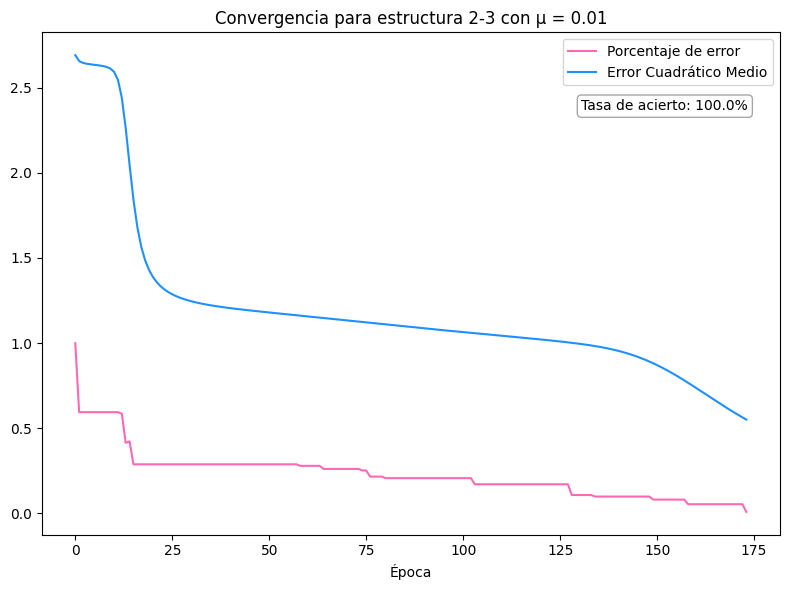

In [72]:
# GRÁFICAS DE ERROR
fig,ax = plt.subplots(figsize=(8,6))
x = range(len(errores_por_epoca))

ax.set(title=f'Convergencia para estructura 2-3 con µ = {mu}')
ax.plot(x, errores_por_epoca, label='Porcentaje de error',color='hotpink')
ax.plot(x, mse_por_epoca, label='Error Cuadrático Medio',color='dodgerblue')
ax.set_xlabel('Época')
ax.legend()
bbox_props = dict(boxstyle='round,pad=0.3',facecolor='white',edgecolor='gray',alpha=0.7)
plt.text(epoca-epoca*0.25,max(mse_por_epoca)-max(mse_por_epoca)*0.12,f'Tasa de acierto: {round(acierto,2)}%',bbox=bbox_props)
plt.tight_layout()
plt.savefig('resultados/convergencia.png')
plt.show()